In [0]:
%%capture
!rm -rf Social-DIstancing-Using-Deep-Learning-and-OpenCV/
!rm -rf darknet
!git clone https://github.com/AlexeyAB/darknet.git
!git clone https://github.com/BoostTag/Social-Distancing.git
%cd darknet/
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights
%cd ../Social-DIstancing-Using-Deep-Learning-and-OpenCV/
%config InlineBackend.figure_format = 'retina'

In [0]:
from darknet import Darknet
import cv2
import matplotlib.pyplot as plt
from utils import *
import imutils
from imutils import perspective
from imutils import contours
import numpy as np
from scipy.spatial import distance as dist
from collections import defaultdict

In [12]:
# Set the location and name of the cfg file
cfg_file = '../darknet/cfg/yolov3.cfg'
# Set the location and name of the pre-trained weights file
weight_file = '../darknet/yolov3.weights'
# Set the location and name of the COCO object classes file
namesfile = '../darknet/data/coco.names'
# Load the network architecture
m = Darknet(cfg_file)
# Load the pre-trained weights
m.load_weights(weight_file)
# Load the COCO object classes
class_names = load_class_names(namesfile)

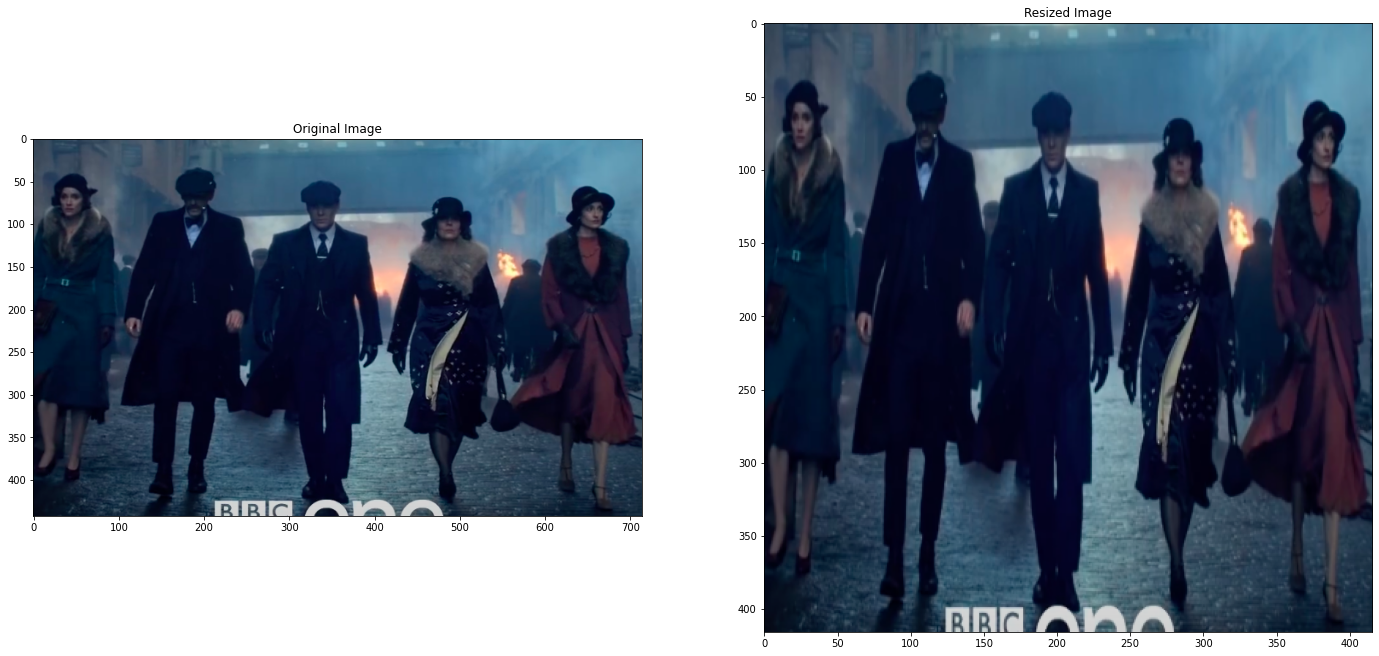

In [22]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]
IMAGE = 'Images/peaky_blinders.png'
# Load the image
img = cv2.imread(IMAGE)

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

In [0]:
nms_thresh = 0.6
iou_thresh = 0.4



It took 1.735 seconds to detect the objects in the image.

Number of Objects Detected: 6 

Objects Found and Confidence Level:

1. person: 0.999998
2. person: 1.000000
3. person: 1.000000
4. person: 1.000000
5. person: 1.000000
6. person: 0.999935


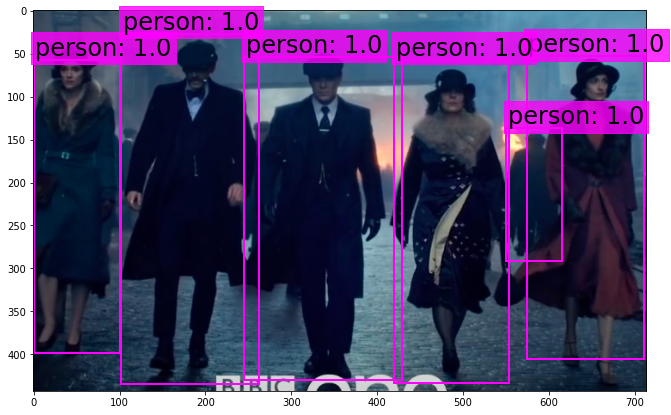

In [24]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [15.0, 7.0]

# Load the image
img = cv2.imread(IMAGE)

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)

In [0]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [0]:
image = cv2.imread(IMAGE)
box_measures = defaultdict(dict)
width = img.shape[1]
height = img.shape[0]
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),(255, 0, 255))
for i, box in enumerate(boxes):    
    x1 = int(np.around((box[0] - box[2]/2.0) * width))
    y1 = int(np.around((box[1] - box[3]/2.0) * height))
    x2 = int(np.around((box[0] + box[2]/2.0) * width))
    y2 = int(np.around((box[1] + box[3]/2.0) * height))

    if x2-x1 > 50:
        box_measures["box"+str(i)] = {"top_left": (x1, y1), "top_right": (x2, y1),"bottom_right": (x2, y2),
                                  "bottom_left": (x1, y2), "center": (int((x1+x2)/2),int((y1+y2)/2))}

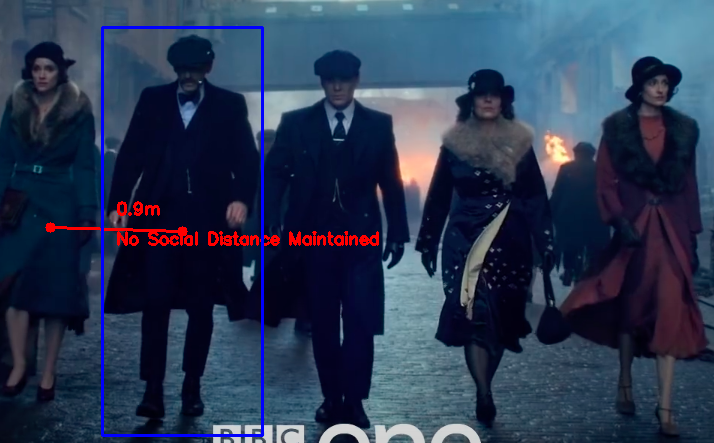

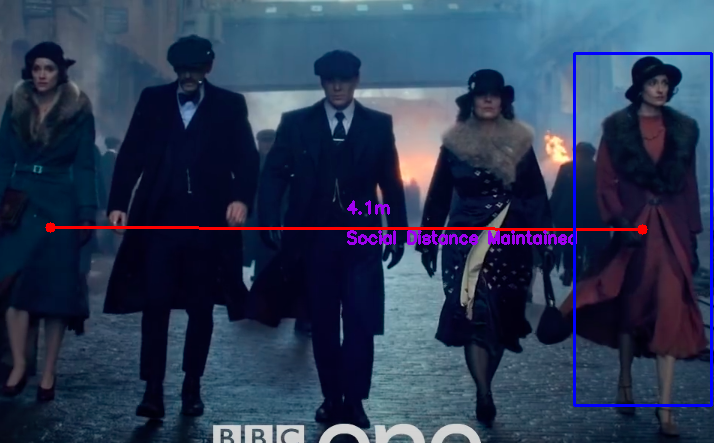

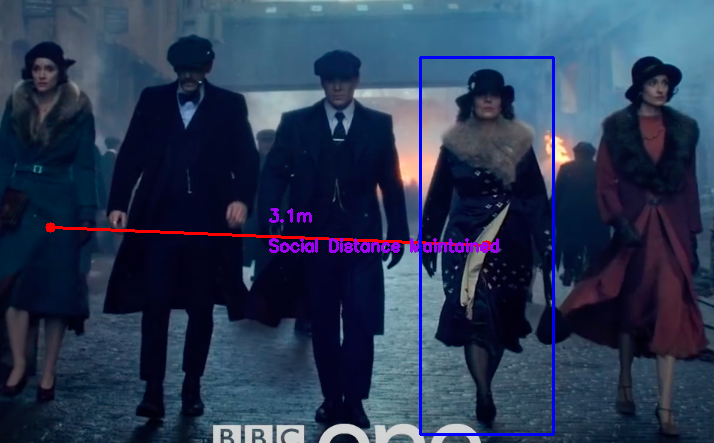

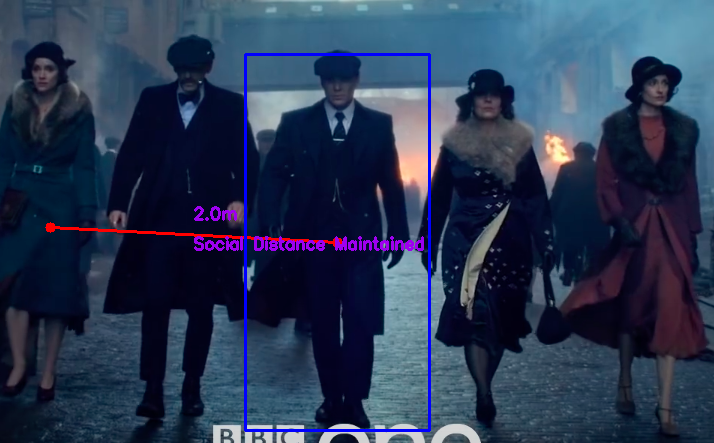

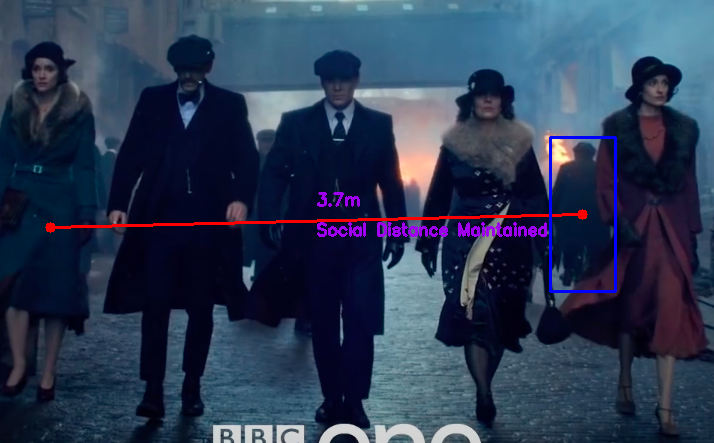

In [31]:
from google.colab.patches import cv2_imshow
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),(255, 0, 255))
box0_array = np.zeros((4,2),dtype=int)
count = 0
refObj = None
for key,v in box_measures.items():
    for i, (k,v) in enumerate(box_measures[key].items()):
        if i ==4:
            break
        box0_array[i,count], box0_array[i, count+1] = v[0],v[1]
        
    cX = np.average(box0_array[:, 0])
    cY = np.average(box0_array[:, 1])
    if refObj is None:
        # unpack the ordered bounding box, then compute the
        # midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-right and
        # bottom-right
        (tl, tr, br, bl) = box0_array
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
        # compute the Euclidean distance between the midpoints,
        # then construct the reference object
        D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
        refObj = (box0_array, (cX, cY), D / 0.70)
        continue
    # draw the contours on the image
    orig = image.copy()
    
    # stack the reference coordinates and the object coordinates
    # to include the object center
    refCoords = np.vstack([refObj[0], refObj[1]])
    objCoords = np.vstack([box0_array, (cX, cY)])
    cv2.rectangle(orig, (refObj[0][0][0], refObj[0][0][1]),
                  (refObj[0][2][0], refObj[0][2][1]), (0, 255, 0), 2)    
    cv2.circle(orig, (int(refObj[1][0]), int(refObj[1][1])), 5, colors[0], -1)
    cv2.circle(orig, (int(cX), int(cY)), 5, colors[0], -1)
    cv2.line(orig, (int(refObj[1][0]), int(refObj[1][1])), (int(cX), int(cY)), colors[0], 2)

    
    D = dist.euclidean((refObj[1][0], refObj[1][1]), (cX, cY)) / refObj[2]
    (mX, mY) = midpoint((refObj[1][0], refObj[1][1]), (cX, cY))
    
    if D > 1.8: #Success
        cv2.putText(orig, "{:.1f}m".format(D), (int(mX), int(mY - 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, colors[1], 2)
        
        cv2.putText(orig, "Social Distance Maintained", (int(mX), int(mY + 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, colors[1], 2)
    else:
        cv2.putText(orig, "{:.1f}m".format(D), (int(mX), int(mY - 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, colors[0], 2)
        
        cv2.putText(orig, "No Social Distance Maintained", (int(mX), int(mY + 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, colors[0], 2)
        
    # show the output image
    cv2.rectangle(orig, box_measures[key]["top_left"], box_measures[key]["bottom_right"],(255,0,0), 2)
    # cv2.imshow("Image", orig)
    cv2_imshow(orig)
    cv2.imwrite("image_"+key+".png", orig)
    cv2.waitKey(0)

In [0]:
import glob
import re
 
img_array = []
each_image_duration = 30
filenames = [ filename for filename in glob.glob("Images/*.png")]
filenames = [x for x in filenames if "peaky" not in x]
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))

for filename in filenames:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('Social_Distancing.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    for _ in range(each_image_duration):
        out.write(img_array[i])
out.release()

In [33]:
filenames

['Images/image_box4.png',
 'Images/image_box1.png',
 'Images/image_box2.png',
 'Images/peaky_blinders.png',
 'Images/image_box3.png']

In [35]:
[x for x in filenames if "peaky" not in x]

['Images/image_box4.png',
 'Images/image_box1.png',
 'Images/image_box2.png',
 'Images/image_box3.png']